# Submission for Assignment 1: OMR

## Course: Computer Vision, SP 21, Indiana University, Bloomington


- This script applies image recognition process to identify musical notes from an image.

- Submission by: [Group 3] Aakash Ahuja, Sahil Tyagi, Rose Mariyappan, Ketan Pimparkar, Nicholas Faro


## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from collections import Counter
from PIL import Image, ImageDraw, ImageFilter,ImageFont
import math
import sklearn
from sklearn.preprocessing import minmax_scale
import glob
from pathlib import Path

In [2]:
os.getcwd() + '\\test-images'

'C:\\Users\\User\\Desktop\\MyDocuments\\MSDS\\Courses\\ComputerVision\\Homework\\Homework1\\test-images'

## Define image locations and constants

In [3]:
base_path = os.getcwd() + '\\test-images'

image1_path = base_path + '\\music1.png'
image2_path = base_path + '\\music2.png'
image3_path = base_path + '\\music3.png'
image4_path = base_path + '\\music4.png'

template1_path = base_path + '\\template1.png'
template2_path = base_path + '\\template2.png'
template3_path = base_path +'\\template3.png'

#image_path = image2_path

In [4]:
sobel_sx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) 
sobel_sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
# sobel_separable_xx = np.array([[1,2,1]])
# sobel_separable_xy = np.array([[1,0,-1]])
# sobel_separable_yx = np.array([[-1,0,1]])
# sobel_separable_yy = np.array([[1,2,1]])

  
sobel_separable_xx = np.array([[1],[2],[1]])
sobel_separable_xy = np.array([[1,0,-1]])
sobel_separable_yx = np.array([[1],[0],[-1]])
sobel_separable_yy = np.array([[1,2,1]])

### Thresholds to detect templates

In [5]:
if image_path == image1_path:
  music_cutoffs = [220,250,245]
elif image_path == image2_path:
  music_cutoffs = [230,254,230]
elif image_path == image3_path:
  music_cutoffs = [220,253,252]
elif image_path == image4_path:
  music_cutoffs = [220,253,220]
else:
  music_cutoffs = [225,250,235]  

NameError: name 'image_path' is not defined

In [6]:
print(music_cutoffs)

[230, 254, 230]


## Staves detection

### Get coordinate spacing using Canny edge detection

In [6]:
def get_coordinates_spacing(image_path, edge_map=None):
  if edge_map is None:
    img_matrix = np.array(Image.open(image_path,mode='r').convert('L'))
    res = cv2.Canny(img_matrix,threshold1 = 255, threshold2 = 255/3)
    note_image = Image.fromarray(res).convert('L')
  else:
    note_image = Image.fromarray(edge_map).convert("L")

  image_arr = np.array(note_image)
  lst = []
  for i in range(image_arr.shape[0]):
    numbers = [image_arr[i,j] for j in range(image_arr.shape[1])]
    lst.append((i,np.round(np.mean(numbers),2)))

  lst1= [t for t in lst if t[1]>81 ] 
  lst1.sort(key=lambda x:x[0],reverse=False)
  treble_stave= lst1[0][0]
  indx = [lst1[k][0] for k in range(len(lst1))]
  sub =  np.diff(indx)
  condition = sub > 4
  condition = np.insert(condition,0,True)
  final_indxs = []
  for m in range(len(indx)):
    if condition[m] == True:
      final_indxs.append(m)
  
  lst3 = [lst1[i] for i in final_indxs]
  indexes = [element[0] for element in lst3]
  sub =  np.diff(indexes)
  mask = np.logical_and(sub > 4, sub < 40)
  sub = sub[mask]
  c = Counter(sub)
  spacing_parameter = c.most_common(2)[0][0]
  
  print(f'{len(indexes)/5} sets of stave lines with mode spacing parameter:{spacing_parameter}')
  
  return(indexes,spacing_parameter)

### Hough transform to get locations and spacing between staves

(382, 76)


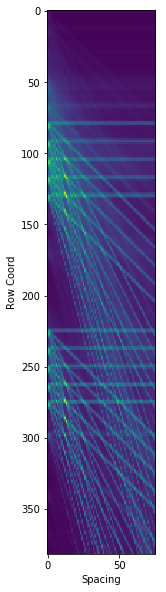

In [12]:
def hough_transform(image):
	note_image = Image.open(image).convert('L')
	axis0_accum = note_image.height
	#the space to explore and vote for each black pixel in the black n' whitye grayscale image
	axis1_accum = math.floor(note_image.height / 5)
	accumulator = np.zeros([axis0_accum, axis1_accum])
	print(accumulator.shape)
	# all pixels lower than this value will be considered as black pixels, hopefully belonging to the lines of the staff.
	pixel_threshold = 180
	# for groups of five lines on a staff
	lines_to_detect = 5

	for x in range(0,note_image.width):
		for y in range(0,note_image.height):
			pixel_val = note_image.getpixel((x,y))
			if pixel_val < pixel_threshold:
				for hough_axis1 in range(1, axis1_accum):
					for space in range(0,lines_to_detect):
						# following the format y = m*x + b where y is y-coord, x is x-coord, 
						# m is slope and b is bias. x and y are in image space, while m and b are in hough space
						# to detect five lines groups, we subsitute b with row coordinate of the first stave line
						# and m by the spacing between the lines
						hough_axis0 = abs(space * hough_axis1 + y)
						# ignore values if they exceed the image height, i.e., dim 0 of accumulator array
						if hough_axis0 < axis0_accum:
							accumulator[hough_axis0, hough_axis1] += 1

	return accumulator

accumulator = hough_transform(image_path)

def plot_hough_transform_space(accumulator):
    plt.figure(figsize=(5,10))
    plt.imshow(accumulator)
    plt.xlabel('Spacing')
    plt.ylabel('Row Coord')
    plt.savefig('hough_transform_space.png')

plot_hough_transform_space(accumulator)

## Rescaling templates

In [7]:
def rescale_templates(spacing_parameter):
    # image_path = image_path

    # im = Image.open(image_path,mode='r').convert('L')
    temp1 = Image.open(template1_path,mode="r").convert('L')
    temp2 = Image.open(template2_path,mode="r").convert('L')
    temp3 = Image.open(template3_path,mode="r").convert('L')

    # im_array = np.array(im)
    temp_array1 = np.array(temp1)
    temp_array2 = np.array(temp2)
    temp_array3 = np.array(temp3)

    height1 = temp_array1.shape[0]
    width1 = temp_array1.shape[1]
    new_height1 = spacing_parameter

    #maintain aspect ratio
    new_width1  = int(new_height1 * (width1 / height1))
    #Resizing temp1 image
    temp1=temp1.resize((new_width1,new_height1))
    temp_array1 = np.array(temp1)


    # scaling template from spacing parameter
    # for template2
    height2 = temp_array2.shape[0]
    width2 = temp_array2.shape[1]
    new_height2 = int(3*spacing_parameter)
    new_width2  = int(new_height2 * (width2 / height2))
    temp2 = temp2.resize((new_width2,new_height2))
    temp_array2 = np.array(temp2)

    # scaling template from spacing parameter
    # for template3
    height3 = temp_array3.shape[0]
    width3 = temp_array3.shape[1]

    new_height3 = int(2.5*spacing_parameter)
    new_width3  = int(new_height3 * (width3 / height3))
    temp3 = temp3.resize((new_width3,new_height3))
    temp_array3 = np.array(temp3)

    return temp_array1, temp_array2, temp_array3

## Hamming distance scoring on original Images

### Calculate hamming distance

In [8]:
def Hamming_Distance(image_scaled,template_scaled):
  #Padding the image to take care of boundaries 
  
  image_padded = np.zeros(shape=(image_scaled.shape[0] + template_scaled.shape[0] - 1, image_scaled.shape[1] + template_scaled.shape[1] -1))
  image_padded[:image_scaled.shape[0], :image_scaled.shape[1]] = image_scaled

  #Calculating Hamming distance now for template matching
  f_ij = np.zeros((image_scaled.shape[0],image_scaled.shape[1]))
  for i in range(image_scaled.shape[0]):
    for j in range(image_scaled.shape[1]):
      patch = image_padded[i:template_scaled.shape[0]+i,j:template_scaled.shape[1]+j]
      #Applying the formula given in the assignment
      f_ij[i,j] = np.sum(np.multiply(patch,template_scaled)) + np.sum(np.multiply((1-patch),(1-template_scaled)))

  f_ij_scaled = 255*(f_ij - f_ij.min())/(f_ij.max() - f_ij.min())      
  f_ij_scaled = f_ij_scaled.astype(np.uint8)
  return(f_ij_scaled)

### Template matching function

In [9]:
def template_matching(img_path,template_cutoff, edge_map=False, debug=False):
  #template_paths = [i[0] for i in template_cutoff]
  cutoffs = [i[1] for i in template_cutoff]
  image_scaled = minmax_scale(np.array(Image.open(img_path,mode="r").convert('L')))
  templates_scaled = [minmax_scale(template_cutoff[i][0]) for i in range(len(template_cutoff))]

  f_ijs = [Hamming_Distance(image_scaled,templates_scaled[i]) for i in range(len(templates_scaled))]

  images = [Image.fromarray(np.where(f_ijs[i] > cutoffs[i],255,0).astype(np.uint8))  for i in range(len(f_ijs))]
  
  return(images)  

### Non Maximum Supression

In [10]:
def non_max_suppression(boxes, overlap_threshold):
    selected_boxes = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1) * (y2 - y1)
    sort_indexes = np.argsort(x1)

    while len(sort_indexes) > 0:
        last = len(sort_indexes) - 1
        last_box = sort_indexes[last]
        selected_boxes.append(last_box)
        suppressed_boxes = [last]
 
        for i in range(0, last):
            current_box = sort_indexes[i]
 
            max_x1 = max(x1[last_box], x1[current_box])
            max_y1 = max(y1[last_box], y1[current_box])
            min_x2 = min(x2[last_box], x2[current_box])
            min_y2 = min(y2[last_box], y2[current_box])
 
            compact_box_area = float(max(0, min_x2 - max_x1)*max(0, min_y2 - max_y1))
            overlap_perc = compact_box_area/area[current_box]
            if overlap_perc > overlap_threshold:
                suppressed_boxes.append(i)

        sort_indexes = np.delete(sort_indexes, suppressed_boxes)
 
    return boxes[selected_boxes]

### Annotation function

In [11]:
def return_notes(k, indexes, spacing_parameter):  
    treble_notes = ['F','D','B','G','E']
    middle_treble_notes = ['E','C','A','F']
    base_notes = ['A','F','D','B','G']
    middle_base_notes = ['G','E','C','A']

    combine_treble_base_notes = treble_notes+base_notes
    # print("combine_treble_base_notes", combine_treble_base_notes)
    
    list_notes = []

    for indx in enumerate(indexes):
        if indx[0]<10:
            list_notes.append((indx[1],combine_treble_base_notes[indx[0]]))
        elif indx[0] >=10 and indx[0]<20:
            list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
        
        elif indx[0] >=20 and indx[0]<30:
            list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
        
        elif indx[0] >=30 and indx[0]<40:
            list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
        
        elif indx[0] >=40 and indx[0]<50:
            list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
        
        elif indx[0] >=50 and indx[0]<60:
            list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))

    # print(list_notes)

    list_coordinates = [a_tuple[0] for a_tuple in list_notes]
    # print(list_coordinates)

    treble_note_f = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==0]
    treble_note_d = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==1]
    treble_note_b = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==2]
    treble_note_g = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==3]
    treble_note_e = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==4]
    base_note_a = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==5]
    base_note_f = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==6]
    base_note_d = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==7]
    base_note_b = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==8]
    base_note_g = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==9]

    for note in enumerate(treble_note_f):
        if k >= treble_note_f[note[0]] - (spacing_parameter/2) -3 and k <treble_note_f[note[0]]-1:
            text = 'F'
            return(text)
        elif k >= treble_note_f[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_f[note[0]]-(spacing_parameter/2)-3:
            text = ''
            return(text)

    for note in enumerate(treble_note_d):
        if k >= treble_note_d[note[0]] - (spacing_parameter/2) -3 and k <treble_note_d[note[0]]-1:
            text = 'D'
            return(text)
        elif k >= treble_note_d[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_d[note[0]]-(spacing_parameter/2)-3:
            text = 'E'
            return(text)


    for note in enumerate(treble_note_b):
        if k >= treble_note_b[note[0]] - (spacing_parameter/2) -3 and k <treble_note_b[note[0]]-1:
            text = 'B'
            return(text)
        elif k >= treble_note_b[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_b[note[0]]-(spacing_parameter/2)-3:
            text = 'C'
            return(text)

    for note in enumerate(treble_note_g):
        if k >= treble_note_g[note[0]] - (spacing_parameter/2) -3 and k <treble_note_g[note[0]]-1:
            text = 'G'
            return(text)
        elif k >= treble_note_g[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_g[note[0]]-(spacing_parameter/2)-3:
            text = 'A'
            return(text)
        

    for note in enumerate(treble_note_e):
        if k >= treble_note_e[note[0]] - (spacing_parameter/2) -3 and k <treble_note_e[note[0]]-1:
            text = 'E'
            return(text)
        elif k >= treble_note_e[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_e[note[0]]-(spacing_parameter/2)-3:
            text = 'F'
            return(text)
        elif k >= treble_note_e[note[0]]-2 and k <= treble_note_e[note[0]]+5:
            text = 'D'
            return(text)
        elif k >= treble_note_e[note[0]] + 6 and k <= treble_note_e[note[0]]+30:
            text = 'B'
            return(text)

    for note in enumerate(base_note_a):
        if k < base_note_a[note[0]]-13 and k >= base_note_a[note[0]] - 30:
            text = 'C'
            return(text)
        elif k >= base_note_a[note[0]]-12 and k <= base_note_a[note[0]]-5:
            text = 'B'
            return(text)
        elif k >= base_note_a[note[0]] - (spacing_parameter/2) -3 and k <base_note_a[note[0]]-1:
            text = 'A'
            return(text)

    for note in enumerate(base_note_f):
        if k >= base_note_f[note[0]] - (spacing_parameter/2) -3 and k <base_note_f[note[0]]-1:
            text = 'F'
            return(text)
        elif k >= base_note_f[note[0]]-(spacing_parameter*2)-1 and k <= base_note_f[note[0]]-(spacing_parameter/2)-3:
            text = 'G'
            return(text)
    
    for note in enumerate(base_note_d):
        if k >= base_note_d[note[0]] - (spacing_parameter/2) -3 and k <base_note_d[note[0]]-1:
            text = 'D'
            return(text)
        elif k >= base_note_d[note[0]]-(spacing_parameter*2)-1 and k <= base_note_d[note[0]]-(spacing_parameter/2)-3:
            text = 'E'
            return(text)
    
    for note in enumerate(base_note_b):
        if k >= base_note_b[note[0]] - (spacing_parameter/2) -3 and k <base_note_b[note[0]]-1:
            text = 'B'
            return(text)
        elif k >= base_note_b[note[0]]-(spacing_parameter*2)-1 and k <= base_note_b[note[0]]-(spacing_parameter/2)-3:
            text = 'C'
            return(text)

    for note in enumerate(base_note_g):
        if k >= base_note_g[note[0]] - (spacing_parameter/2) -3 and k <base_note_g[note[0]]-1:
            text = 'G'
            return(text)
        elif k >= base_note_g[note[0]]-(spacing_parameter*2)-1 and k <= base_note_g[note[0]]-(spacing_parameter/2)-3:
            text = 'A'
            return(text)    


### Setup Template cutoffs

In [12]:
def get_cutoff(image_path, temp_array1, temp_array2, temp_array3):
    if image_path == image1_path:
        music_cutoffs = [220,250,245]
    elif image_path == image2_path:
        music_cutoffs = [230,254,230]
    elif image_path == image3_path:
        music_cutoffs = [220,253,252]
    elif image_path == image4_path:
        music_cutoffs = [220,253,220]
    else:
        music_cutoffs = [225,250,235]  

    template_cutoff = [(temp_array1,music_cutoffs[0]),(temp_array2,music_cutoffs[1]),(temp_array3,music_cutoffs[2])]

    return template_cutoff

## Display output function

### Confidence function

In [13]:
def confidence_score(img, tmp, bbox, use_cv=None):
    if use_cv is None:
        img = img.convert('L')
        img_arr   = np.asarray(img,dtype=np.uint8)[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]
        
        tmp_image = Image.fromarray(tmp).convert('L')
        t_arr     = np.asarray(tmp_image,dtype=np.uint8)
        x = min(img_arr.shape[0],t_arr.shape[0])
        y = min(img_arr.shape[1],t_arr.shape[1])
        img_arr = np.reshape(img_arr[:x,:y], (x,y))
        t_arr = np.reshape(t_arr[:x,:y], (x,y))

        distance = (np.sum(img_arr == t_arr)) / (img_arr.shape[0]*img_arr.shape[1])
        return distance
    else:
        method = cv2.TM_CCORR_NORMED # cv2.TM_CCOEFF
        tmp_image = Image.fromarray(tmp).convert('RGB')
        img_array   = np.asarray(img,dtype=np.uint8)[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]
        tmp_img_array     = np.asarray(tmp_image,dtype=np.uint8)
        # tmp_img_array     = tmp
        res = cv2.matchTemplate(img_array,tmp_img_array,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        return max_val

In [14]:
def show_output(image_path, images, template_cutoff, indexes, spacing_parameter):
    # might have to pass indexes
    colors = ['red','green','blue']
    convert_image = Image.open(image_path).convert('L')
    im1 = convert_image.convert('RGB')
    draw = ImageDraw.Draw(im1)
    fontsize = 15
    font = ImageFont.truetype('arial.ttf',fontsize)
    coordinates = [(0,0)]
    text_output = []
    for k in range(len(images)):
        #path = template_cutoff[k][0]
        temp_array_1 = template_cutoff[k][0]
        #temp_array_1 = np.array(Image.open(path,mode="r").convert('L'))
        temp = np.array(images[k])
        box_endpoints = []
        for i in range(0,temp.shape[0]-40):
            for j in range(20,temp.shape[1]-30):
                if temp[i,j] == 255:
                    x = i
                    y = j
                    x2 = x + temp_array_1.shape[0]
                    y2 = y + temp_array_1.shape[1]
                    box_endpoints.append([y,x,y2,x2])

        boxes_out = non_max_suppression(boxes=np.array(box_endpoints), overlap_threshold=0.3)
        for box in boxes_out:
            if box[0] >65  and box[1]>10 : 
                bbox = ((box[0]-6,box[1]-2),(box[2]+1,box[3]+1))          
                draw.rectangle(bbox, outline= colors[k] ,width=2) 
                # might have to pass indexes
                text = return_notes(box[1], indexes, spacing_parameter)
                if text == None:
                    text = ''
                else:
                    text = text
                
                if k ==0:
                    symbol = "offilled_note"          
                    draw.text((box[0]-14,box[1]-16), text, fill='red', font=font)
                elif k ==1:
                    symbol = "quarter_rest"
                    text = '_'
                    draw.text((box[0]-12,box[1]-16), 'quarter_rest', fill='green', font=font)
                elif k ==2:
                    symbol = 'eighth_rest'
                    text = "_"
                    draw.text((box[0]-12,box[1]-16), 'eighth_rest', fill='blue', font=font)
                
                out_row = str(box[1]-2)   #y coord
                out_col = str(box[0]-6)   #x coord
                out_height = str(temp_array_1.shape[0])
                out_width = str(temp_array_1.shape[1]) 
                out_symbol = symbol
                out_pitch = text
                bbox=np.array([[box[0],box[1]], [box[2],box[3]]])

                out_conf = str(round(confidence_score(im1, temp_array_1, bbox, None), 3))
                # out_conf = "CONF"

                text_output.append([out_row, out_col, out_height, out_width, out_symbol, out_pitch, out_conf])

    return (im1, text_output)

### Apply template matching on original images and generate output image

In [15]:
def f(image_path):
    indexes, spacing_parameter = get_coordinates_spacing(image_path)
    print("Staves' indexes: ", indexes)
    temp_array1, temp_array2, temp_array3 = rescale_templates(spacing_parameter)

    template_cutoff = get_cutoff(image_path,temp_array1, temp_array2, temp_array3)
    template_matched_images = template_matching(image_path,template_cutoff)
    im1, text_output = show_output(image_path, template_matched_images, template_cutoff, indexes, spacing_parameter)
    output_image=Path(image_path).stem + "_output.png"
    im1.save(output_image)
    text_out_name = Path(image_path).stem + "_text_op.txt"
    with open(text_out_name, 'w+') as fout:
        for lines in text_output:
            fout.write(','.join(lines)+"\n")
    return im1  

2.0 sets of stave lines with mode spacing parameter:12
Staves' indexes:  [29, 41, 52, 64, 75, 150, 162, 173, 185, 196]


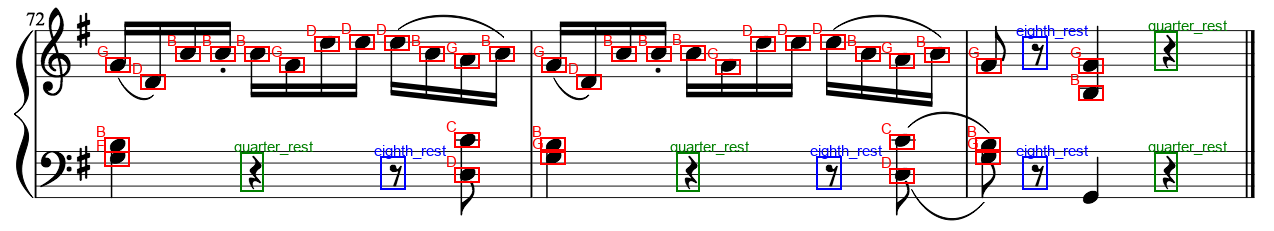

In [22]:
f(image1_path)

2.0 sets of stave lines with mode spacing parameter:12
Staves' indexes:  [29, 41, 52, 64, 75, 150, 162, 173, 185, 196]


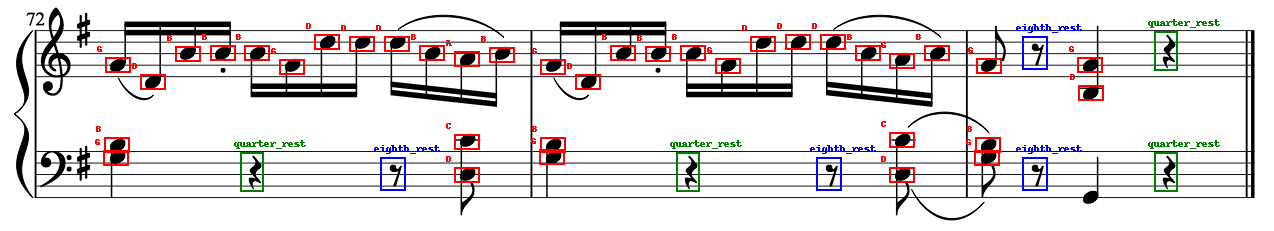

In [51]:
f(image1_path)  

In [ ]:
f(image2_path)  

2.0 sets of stave lines with mode spacing parameter:12
Staves' indexes:  [78, 90, 103, 116, 128, 223, 236, 248, 261, 273]


2.0 sets of stave lines with mode spacing parameter:12
Staves' indexes:  [78, 90, 103, 116, 128, 223, 236, 248, 261, 273]


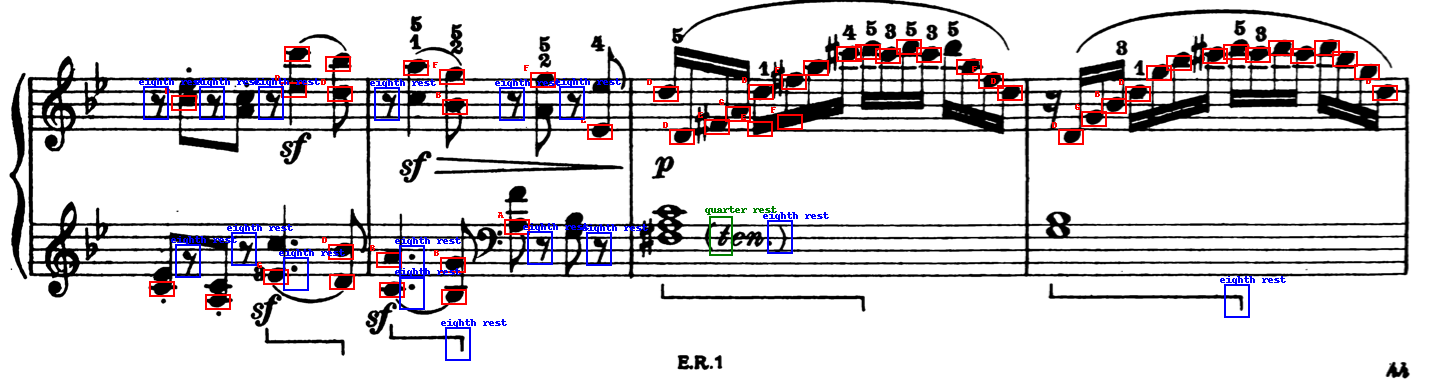

In [38]:
f(image2_path)  

4.0 sets of stave lines with mode spacing parameter:11
Staves' indexes:  [50, 59, 70, 80, 88, 150, 160, 169, 179, 190, 302, 311, 322, 332, 343, 402, 413, 421, 432, 442]


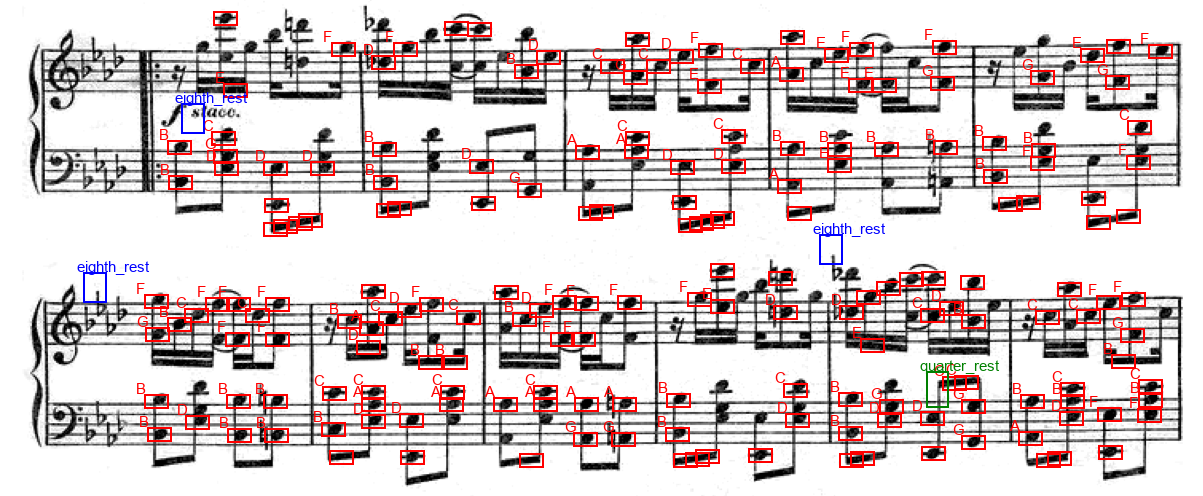

In [35]:
f(image3_path) 

4.0 sets of stave lines with mode spacing parameter:11
Staves' indexes:  [50, 59, 70, 80, 88, 150, 160, 169, 179, 190, 302, 311, 322, 332, 343, 402, 413, 421, 432, 442]


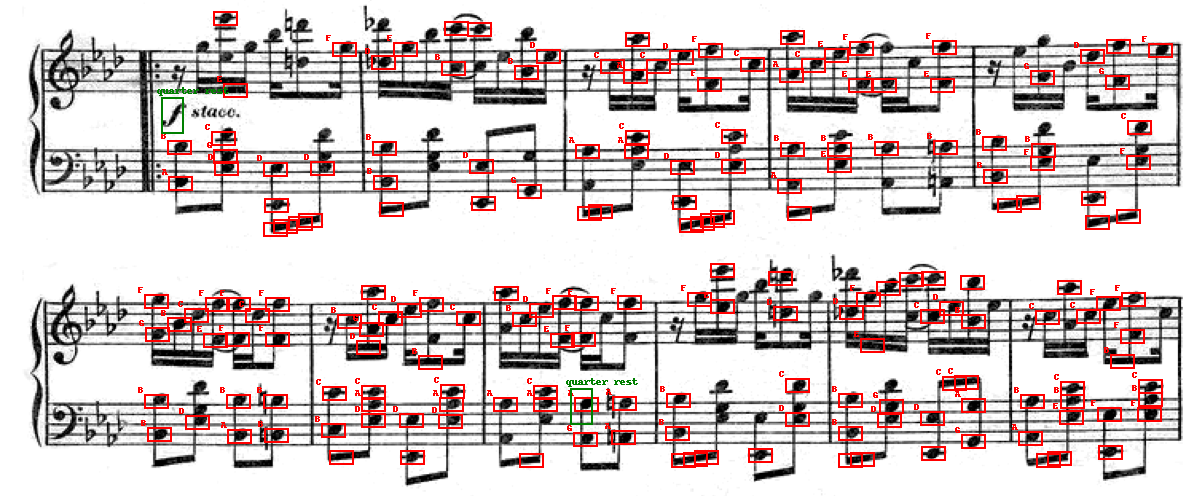

In [39]:
f(image3_path)  

2.0 sets of stave lines with mode spacing parameter:17
Staves' indexes:  [54, 71, 87, 104, 121, 265, 281, 298, 318, 331]


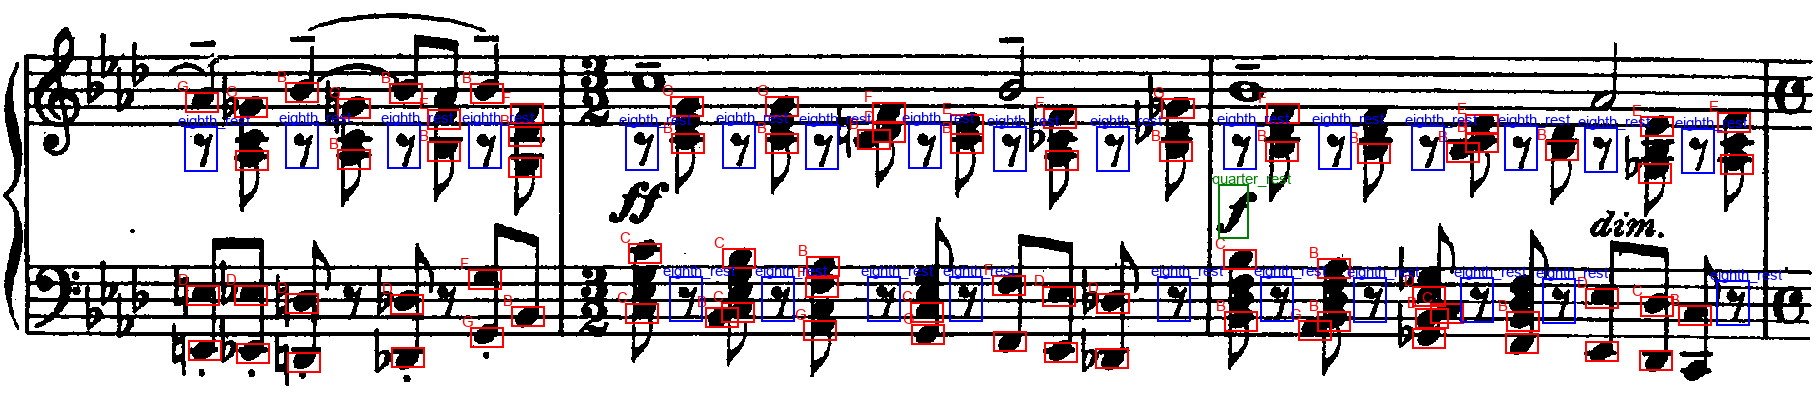

In [25]:
f(image4_path)

2.0 sets of stave lines with mode spacing parameter:17
Staves' indexes:  [54, 71, 87, 104, 121, 265, 281, 298, 318, 331]


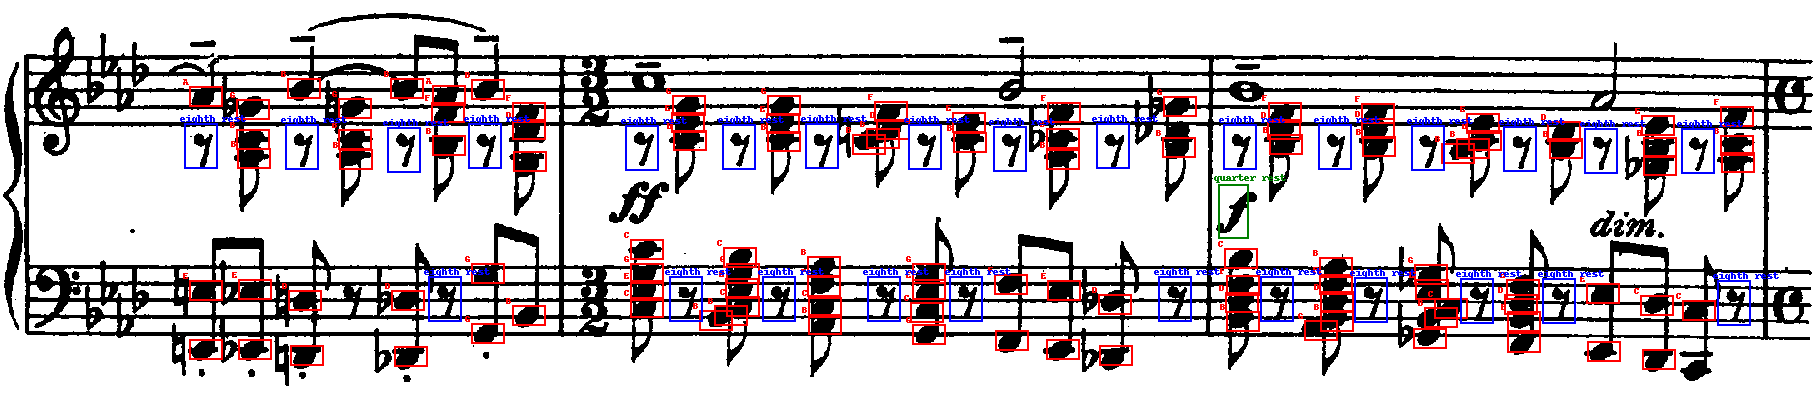

In [40]:
f(image4_path)  

## Convolution

### 2D convolution

In [ ]:
def convolve(img_array, kernel):
    kernel_rows, kernel_cols = kernel.shape
    img_rows, img_cols = img_array.shape

    # flip the kernel
    flipped_kernel = np.zeros(kernel.shape)    
    ## column flips
    for i in range(flipped_kernel.shape[1]):
        flipped_kernel[:,i] = kernel[:,kernel_cols-i-1]
    kernel = flipped_kernel.copy()
    ## row flips
    for i in range(flipped_kernel.shape[0]):
        flipped_kernel[i,:] = kernel[kernel_rows-i-1,:]
    kernel = flipped_kernel.copy()

    # Handle broders by padding the image with white pixels.
    # padwidth = kernel_rows // 2
    # self.img_array_padded = np.pad(self.img_array, padwidth, 
    #                             mode='constant', constant_values=255)
    
    row_padwidth = kernel_rows // 2
    col_padwidth = kernel_cols // 2
    print(f"INFO: Kernel shape={kernel.shape}, row_padwidth={row_padwidth};col_padwidth={col_padwidth}")
    img_array_padded = np.pad(array=img_array, 
                                pad_width=((row_padwidth,row_padwidth), (col_padwidth,col_padwidth)), 
                                mode='constant', 
                                constant_values=255)

    # cross correlation
    img_array_out = np.zeros(img_array.shape)

    for y in range(img_cols):
        for x in range(img_rows):
            img_array_out[x, y] = \
            (kernel * img_array_padded[x:x+kernel_cols, y:y+kernel_rows]).sum()

    return img_array_out

### Separable convolution




In [ ]:
def separable_convolve(array_name, h_kernel, v_kernel):
    kernel_rows, kernel_cols = h_kernel.shape
    img_rows, img_cols = array_name.shape

    # print("array shape: ", array_name.shape)
    
    # Handle broders by padding the image with white pixels.
    padwidth = kernel_cols // 2
    array_name_padded = np.pad(array_name, padwidth, 
                                mode='constant', constant_values=255)

    # convoution in the horizontal direction
    array_name_out_tmp = np.zeros((array_name.shape[0]+padwidth+1, array_name.shape[1]+padwidth+1))
    # print("array_name_out_tmp ", array_name_out_tmp.shape)
    for x in range(padwidth,img_rows+1):
        for y in range(padwidth,img_cols+1):
            array_name_out_tmp[x, y] = (h_kernel * array_name_padded[x-padwidth:x+padwidth+1,y]).sum()

    # convoution in the vertical direction
    array_name_out = np.zeros((array_name.shape[0]+padwidth+1, array_name.shape[1]+padwidth+1))
    # print("array_name_out ", array_name_out.shape)
    for x in range(padwidth,img_rows+1):
        for y in range(padwidth,img_cols+1):
            array_name_out[x, y] = (v_kernel * array_name_out_tmp[x,y-padwidth:y+padwidth+1]).sum()
    
    array_name_output = array_name_out[padwidth:img_rows+1, padwidth:img_cols+1]
    # print("Convolved image:\n", array_name_output.shape)
    return array_name_output

## Edge detection

### Sobel edge detection using 2D convolution

In [ ]:
def edge_detect_sobel(image_array, with_test=False, figsize=(10,8)):
    """
    Method to perform edge detection using sobel operator and 2D convolution
    """
    convolved_x = convolve(image_array, sobel_sx)
    convolved_y = convolve(image_array, sobel_sy)
    edge_map = np.sqrt(convolved_x**2 + convolved_y**2)
    
    if with_test:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        axs[0,0].imshow(img_array, 'gray')
        axs[0,0].set_title("Original image")
        axs[0,1].imshow(edge_map, 'gray')
        axs[0,1].set_title("Edge map of image")
        axs[1,0].imshow(convolved_x, 'gray')
        axs[1,0].set_title("Sobel_X convolution")
        axs[1,1].imshow(convolved_y, 'gray')
        axs[1,1].set_title("Sobel_Y convolution")
        
    return edge_map

### Sobel edge detection using separable convolution

In [ ]:
def edge_detect_sobel_separable(array_name, image_path, type_, with_test=False):
    edge_thresholds = {
        'template1.png': 180,
        'template2.png': 140,
        'template3.png': 140,
        'music1.png' : 160,
        'music2.png' : 120,
        'music3.png' : 220,
        'music4.png' : 160
    }
    convolved_separable_x = separable_convolve(array_name, sobel_separable_xx, sobel_separable_xy)
    convolved_separable_y = separable_convolve(array_name, sobel_separable_yx, sobel_separable_yy)
   
    edge_map_separable = np.sqrt(convolved_separable_x**2 + convolved_separable_y**2)

    print(f"DEBUG: Img size {array_name.shape} edge_map_separable size {edge_map_separable.shape}")
    
    if with_test:
        dpi = 80
        height, width = np.array(array_name.shape, dtype=float) / dpi
        fig, axs = plt.subplots(2, 2, figsize=(width, height), dpi=dpi)
        fig.tight_layout()
        axs[0,0].imshow(array_name, 'gray')
        axs[0,0].set_title("Original image")
        axs[0,1].imshow(edge_map_separable, 'gray')
        axs[0,1].set_title("Edge map of image (separable cov)")
        axs[1,0].imshow(convolved_separable_x, 'gray')
        axs[1,0].set_title("Sobel_X separable convolution")
        axs[1,1].imshow(convolved_separable_y, 'gray')
        axs[1,1].set_title("Sobel_Y separable convolution")

    if type_=='image':
        edge_map_separable = edge_map_separable / edge_map_separable.max() * 255
    edge_map_separable_theta = np.arctan2(convolved_separable_y, convolved_separable_x)
    
    threshold = edge_thresholds.get(Path(image_path).name)
    edge_map_separable = np.where(edge_map_separable>threshold, 255, 0) 
    
    return edge_map_separable, edge_map_separable_theta

### Show sobel edge detection using separable convolution

In [ ]:
def show_edge_maps(image_path, type_, save_fig=False, debug=False):
    img_obj = Image.open(image_path).convert("L")
    img_array = np.asarray(img_obj)
    edge_map_separable, edge_map_separable_theta = edge_detect_sobel_separable(img_array, image_path, type_=type_, with_test=False)
    if debug:
        if type_ == 'image':
            figsize=(20,8)
        else:
            figsize=(5,4)
        plt.figure(figsize=figsize)
        plt.imshow(edge_map_separable, 'gray')
        plt.show()
        plt.figure(figsize=figsize)
        plt.imshow(edge_map_separable_theta, 'gray')
        plt.show()
        # name = Path(image_path).stem
        # plt.savefig(name+"_edge_maps.png")
    else:
        if type_ == 'image':
            dpi = 100
            height, width = np.array(img_array.shape, dtype=float) / dpi
        else:
            dpi = 100
            height, width = 15, 8
            
        fig, axs = plt.subplots(1, 3, figsize=(width, height), dpi=dpi)
        fig.tight_layout()
        axs[0].imshow(img_array, 'gray')
        axs[0].set_title("Original image")
        axs[1].imshow(edge_map_separable, 'gray')
        axs[1].set_title("Edge map (separable)")
        axs[2].imshow(edge_map_separable_theta, 'gray')
        axs[2].set_title("Edge map theta (separable)")
        if save_fig:
            name = Path(image_path).stem
            fig.savefig(name+"_edge_maps.png", bbox_inches='tight')


DEBUG: Img size (231, 1274) edge_map_separable size (231, 1274)


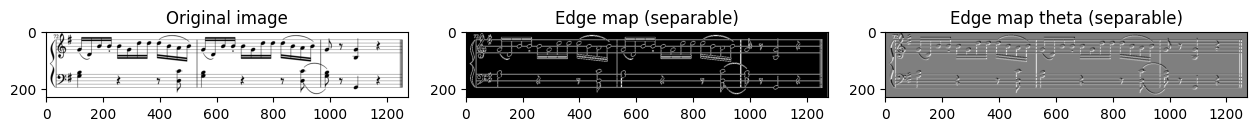

In [ ]:
show_edge_maps(image1_path, 'image', False, False)

DEBUG: Img size (11, 17) edge_map_separable size (11, 17)


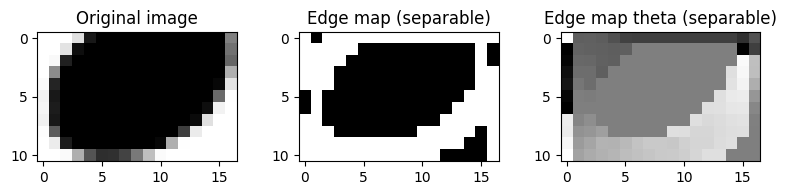

In [ ]:
show_edge_maps(template1_path, 'template', False, False)

## Hamming distance scoring on sobel edge maps

This approach proved to be resource intensive and the provided output wasn't comparable with the Hamming distance approach. Therefore, we discontinued to use this approach.